# Extra Material: Cutting Stock Production

This is a version of the cutting stock problem intended for actual use. The narrative text has been largely removed.

## Code Library

In [4]:
# install Pyomo and solvers
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
SOLVER_MILO = "cbc"
SOLVER_MINLO = "couenne"

In [6]:
import matplotlib.pyplot as plt
import pyomo.environ as pyo    


def make_patterns(stocks, finish):
    """
    Generates patterns of feasible cuts from stock lengths to meet specified finish lengths.

    Parameters:
    stocks (dict): A dictionary where keys are stock identifiers and values are dictionaries 
                   with key 'length' representing the length of each stock.

    finish (dict): A dictionary where keys are finish identifiers and values are dictionaries
                   with key 'length' representing the required finish lengths.

    Returns:
    patterns (list): A list of dictionaries, where each dictionary represents a pattern of cuts. 
                   Each pattern dictionary contains 'stock' (the stock identifier) and 'cuts' 
                   (a dictionary where keys are finish identifiers and the value is the number 
                   of cuts from the stock for each finish).
    """
    patterns = []
    for f in finish:
        feasible = False
        for s in stocks:
            
            # max number of f that fit on s
            num_cuts = int(stocks[s]['length']/finish[f]['length'])
            
            # make pattern and add to list of patterns
            if num_cuts > 0:
                feasible = True
                cuts_dict = {key: 0 for key in finish.keys()}
                cuts_dict[f] = num_cuts
                patterns.append({'stock': s, 'cuts': cuts_dict})
                    
        if not feasible:
            print(f"No feasible pattern was found for {f}")
            return []
    return patterns


def cut_patterns(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, len(patterns)-1)
    
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeIntegers)

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        s = {p: patterns[p]['stock'] for p in m.P}
        c = {p:  stocks[s[p]]['cost'] for p in m.P}
        return sum(c[p] * m.x[p] for p in m.P)

    @m.Constraint(m.F)
    def demand(m, f):
        a = {p: patterns[p]['cuts'][f] for p in m.P}
        return sum(a[p] * m.x[p] for p in m.P) >= finish[f]['demand']
    
    solver = pyo.SolverFactory(SOLVER_MILO)
    solver.solve(m)
    return [m.x[p]() for p in m.P], m.cost()


def generate_pattern_dual(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, len(patterns)-1)
    
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        s = {p: patterns[p]['stock'] for p in m.P}
        c = {p: stocks[s[p]]['cost'] for p in m.P}
        return sum(c[p] * m.x[p] for p in m.P)

    @m.Constraint(m.F)
    def demand(m, f):
        a = {p: patterns[p]['cuts'][f] for p in m.P}
        return sum(a[p] * m.x[p] for p in m.P) >= finish[f]['demand']
    
    # solve and get duals
    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    solver = pyo.SolverFactory('cbc')
    solver.solve(m)
    
    # solve for reduced cost for each stock
    @m.Block(m.S)
    def subprob(b, s):
        m = b.model()
        b.a = pyo.Var(m.F, domain=pyo.NonNegativeIntegers)
        
        @b.Objective(sense=pyo.maximize)
        def marginal_value(b):
            return  sum(b.a[f] * m.dual[m.demand[f]] for f in m.F)
        
        @b.Constraint()
        def stock_length(b):
            return sum(b.a[f] * finish[f]['length'] for f in m.F) <= stocks[s]['length']
    
        pyo.SolverFactory(SOLVER_MILO).solve(b)
        
        return b
        
    reduced_value = [m.subprob[s].marginal_value() - stocks[s]['cost']  for s in m.S]
    s = list(m.S)[reduced_value.index(max(reduced_value))]
    return {'stock': s, 'cuts': {f: round(m.subprob[s].a[f]()) for f in m.F}}


def generate_pattern_bilinear(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, len(patterns)-1)
    
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    m.xp = pyo.Var(domain=pyo.NonNegativeReals)
    
    def a_bounds(m, f):
        return (0, max([int(stocks[s]['length']/finish[f]['length']) for s in m.S]))
    m.ap = pyo.Var(m.F, domain=pyo.NonNegativeIntegers, bounds=a_bounds)
    m.bp = pyo.Var(m.S, domain=pyo.Binary)

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        s = {p: patterns[p]['stock'] for p in m.P}
        c = {p:  stocks[s[p]]['cost'] for p in m.P}
        return sum(c[p] * m.x[p] for p in m.P) + m.xp * sum(m.bp[s] * stocks[s]['cost'] for s in m.S)
    
    @m.Constraint()
    def sum_to_one(m):
        return sum(m.bp[s] for s in m.S) == 1
    
    @m.Constraint()
    def add_pattern(m):
        return sum(m.ap[f] * finish[f]['length'] for f in m.F) <= sum(m.bp[s] * stocks[s]['length'] for s in m.S)

    @m.Constraint(m.F)
    def demand(m, f):
        return sum(patterns[p]['cuts'][f] * m.x[p] for p in m.P) + m.ap[f] * m.xp >= finish[f]['demand']
    
    solver = pyo.SolverFactory(SOLVER_MINLO)
    solver.solve(m)
    new_pattern = {'stock': [s for s in m.S if m.bp[s]() > 0.5][0], 
                   'cuts': {f: round(m.ap[f]()) for f in m.F}}
    return new_pattern


def cut_stock(stocks, finish):
    # Generate initial set of patterns
    patterns = make_patterns(stocks, finish)

    # Phase 1: Generate patterns using dual method
    print("Phase 1 ", end=".")
    new_pattern = generate_pattern_dual(stocks, finish, patterns)
    while new_pattern not in patterns:
        patterns.append(new_pattern)
        new_pattern = generate_pattern_dual(stocks, finish, patterns)
        print(end=".")
        
    x, cost = cut_patterns(stocks, finish, patterns)
    print(f" Cost = {cost}")

    # Phase 2: Generate patterns using bilinear method
    print("Phase 2 ", end=".")
    new_pattern = generate_pattern_bilinear(stocks, finish, patterns)
    while new_pattern not in patterns:
        patterns.append(new_pattern)
        new_pattern = generate_pattern_bilinear(stocks, finish, patterns)
        print(end=".")
    
    x, cost = cut_patterns(stocks, finish, patterns) 
    print(f" Cost = {cost}")
    
    # Get the indices of non-zero patterns
    non_zero_indices = [index for index, value in enumerate(x) if value > 0]

    # Return only the non-zero patterns, their corresponding values, and the cost
    return [patterns[index] for index in non_zero_indices], [x[index] for index in non_zero_indices], cost


def plot_patterns(stocks, finish, patterns):  
    # set up figure parameters
    lw = 0.6
    cmap = plt.get_cmap("tab10")
    colors = {f: cmap(k % 10) for k, f in enumerate(finish.keys())}
    fig, ax = plt.subplots(1, 1, figsize=(8, 0.05 + 0.4*len(patterns)))
    
    for k, pattern in enumerate(patterns):
        # get stock key/name
        s = pattern['stock']
        
        # plot stock as a grey background
        y_lo = (-k - lw/2, -k - lw/2)
        y_hi = (-k + lw/2, -k + lw/2)
        ax.fill_between((0, stocks[s]['length']), y_lo, y_hi, color="k", alpha=0.1)
        
        # overlay finished parts
        xa = 0
        for f, n  in pattern['cuts'].items():
            for j in range(n):
                xb = xa + finish[f]['length']
                ax.fill_between((xa, xb), y_lo, y_hi, alpha=1.0, color=colors[f])
                ax.plot((xb, xb), (y_lo[0], y_hi[0]), 'w', lw=1, solid_capstyle="butt")
                ax.text((xa + xb)/2, -k, f, ha="center", va="center", fontsize=6, color="w", weight="bold")
                xa = xb
        
    # clean up axes
    ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    ax.set_yticks(range(0, -len(patterns), -1), [pattern['stock'] for pattern in patterns], fontsize=8)
    return ax

def plot_nonzero_patterns(stocks, finish, patterns, x, cost):
    k = [j for j, _ in enumerate(x) if _ > 0]
    ax = plot_patterns(stocks, finish, [patterns[j] for j in k])
    ticks = [f"{x[k]} x {pattern['stock']}" for k, pattern in enumerate(patterns) if x[k] > 0]
    ax.set_yticks(range(0, -len(k), -1), ticks, fontsize=8)
    ax.set_title(f"Cost = {round(cost,2)}", fontsize=10)
    return ax
       

## Problem Data

In [8]:
stocks = {
    '2x4 96': {'length': 96, 'cost': 1},
} 

finish = {
    '70': {'length': 70, 'demand': 2},  # base side rails (2)
    '48': {'length': 48, 'demand': 2},  # seat frame sides (2)
    '41': {'length': 41, 'demand': 4},  # seat slats (4)
    '29 3/4': {'length': 29.75, 'demand': 2},  # back rails (2)
    '24': {'length': 24, 'demand': 1},  # seat top stile (1) + back top stile (1)
    '22 3/4': {'length': 22.75, 'demand': 4},  # back slats (4)
    '19': {'length': 19, 'demand': 3},  # base cross rails (3)
    '18 3/4': {'length': 18.75, 'demand': 1},  # bottom of support brace
    '17': {'length': 17, 'demand': 2},  # seat top stile (1) + back top stile (1)
    '16': {'length': 16, 'demand': 4},  # base end rails (2) + base bracket supports (2)
    '12': {'length': 12, 'demand': 1},  # rip to make 2 back support braces
    '8 1/2': {'length': 8.5, 'demand': 4},  # back support block
}

In [9]:
# add kerf width
kerf = 0.25

for s in stocks:
    stocks[s]["length"] += kerf
    
for f in finish:
    finish[f]["length"] += kerf
    
display(stocks)
display(finish)

{'2x4 96': {'length': 96.25, 'cost': 1}}

{'70': {'length': 70.25, 'demand': 2},
 '48': {'length': 48.25, 'demand': 2},
 '41': {'length': 41.25, 'demand': 4},
 '29 3/4': {'length': 30.0, 'demand': 2},
 '24': {'length': 24.25, 'demand': 1},
 '22 3/4': {'length': 23.0, 'demand': 4},
 '19': {'length': 19.25, 'demand': 3},
 '18 3/4': {'length': 19.0, 'demand': 1},
 '17': {'length': 17.25, 'demand': 2},
 '16': {'length': 16.25, 'demand': 4},
 '12': {'length': 12.25, 'demand': 1},
 '8 1/2': {'length': 8.75, 'demand': 4}}

## Solution

Phase 1 ..................... Cost = 9.0
Phase 2 ..... Cost = 9.0


<Axes: title={'center': 'Cost = 9.0'}>

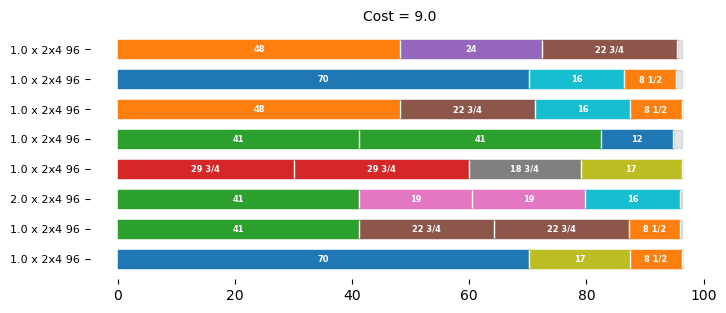

In [7]:
patterns, x, cost = cut_stock(stocks, finish)
plot_nonzero_patterns(stocks, finish, patterns, x, cost)